# Multi-Label Emotion Detection

### En-nadri Nouhayla

####  Objective
The goal  is to build an NLP model that can detect **multiple emotions** in a single sentence.
Unlike simple sentiment analysis (positive/negative), real human text can express **several emotions at once** — for example:
> "I'm thrilled for the promotion, but terrified of the new responsibilities."

This model should recognize both **joy** and **fear** in such cases.

####  Dataset

We use the **GoEmotions** dataset from Google Research, which contains 43 000+ English Reddit comments
annotated with **27 fine-grained emotion labels** (e.g. joy, sadness, pride, fear, gratitude...).
Each text can have 1 – 6 labels.


### Setup and Imports

In [ ]:
import os, json, random, re
from pathlib import Path
from collections import Counter
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    f1_score, precision_recall_curve, classification_report,
    accuracy_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier





c:\speech-text-recognition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)

BASE = Path.cwd()
DATA_DIR = BASE / "../data"
MODEL_DIR = BASE / "../models"
for d in [DATA_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)


### Loading the Dataset:

In [6]:
ds = load_dataset("go_emotions")
train_ds, val_ds, test_ds = ds["train"], ds["validation"], ds["test"]

features = train_ds.features
label_names = features["labels"].feature.names 
NUM_LABELS = len(label_names)
print("Labels:", NUM_LABELS, label_names[:10], "...")

for i in range(3):
    row = train_ds[i]
    print("\ntext:", row["text"][:200])
    print("labels:", [label_names[j] for j in row["labels"]])



Labels: 28 ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment'] ...

text: My favourite food is anything I didn't have to cook myself.
labels: ['neutral']

text: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
labels: ['neutral']

text: WHY THE FUCK IS BAYLESS ISOING
labels: ['anger']


#### Exploratory Data Analysis (EDA)

,label,count
27,neutral,14219
0,admiration,4130
4,approval,2939
15,gratitude,2662
3,annoyance,2470
1,amusement,2328
7,curiosity,2191
18,love,2086
10,disapproval,2022
20,optimism,1581


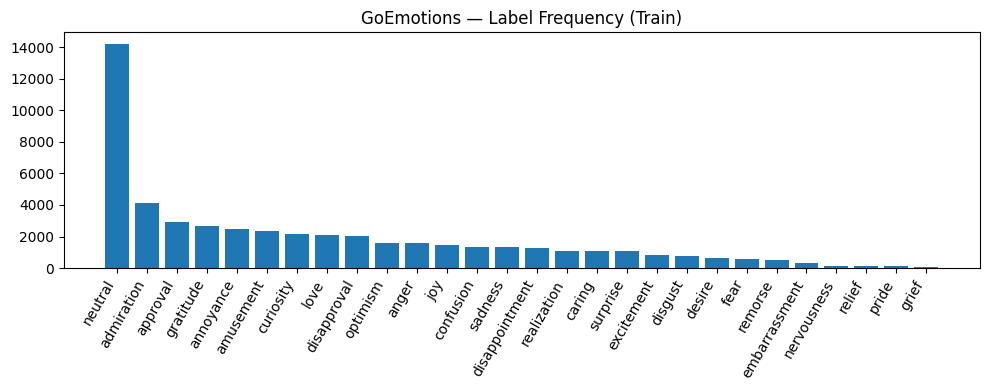

Avg labels per sample (train): 1.177 | density: 0.0420


In [7]:
freq = Counter()
for labs in train_ds["labels"]:
    freq.update(labs)

counts = np.array([freq.get(i, 0) for i in range(NUM_LABELS)])
counts_df = pd.DataFrame({"label": label_names, "count": counts}).sort_values("count", ascending=False)
display(counts_df.head(10))

plt.figure(figsize=(10,4))
plt.bar(counts_df["label"], counts_df["count"])
plt.xticks(rotation=60, ha="right")
plt.title("GoEmotions — Label Frequency (Train)")
plt.tight_layout()
plt.show()

cardinality = np.mean([len(l) for l in train_ds["labels"]])
density = cardinality / NUM_LABELS
print(f"Avg labels per sample (train): {cardinality:.3f} | density: {density:.4f}")


### Preprocessing

In [ ]:
URL_RE = re.compile(r"https?://\S+|www\.\S+")
USER_RE = re.compile(r"@[A-Za-z0-9_]+")

'''
building the output and input matrices

'''
## here we are going to replace each url with the token <URL> 
# and each user mention with the token <USER> 
# and then we will remove all the extra spaces and make the text lowercase
def clean_for_tfidf(t: str) -> str:
    t = URL_RE.sub("<URL>", t)
    t = USER_RE.sub("<USER>", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    return t

### converting the lables into 
# Build X (texts) and Y (multi-hot labels) for each split
#? MultiLabelBinarizer is from scikit-learn converts those lists into a binary matrix
mlb = MultiLabelBinarizer(classes=list(range(NUM_LABELS)))
mlb.fit(train_ds["labels"]) 

# Extract raw texts and encode labels for each split

Xtr_raw = train_ds["text"]
# so this will Take the list of label IDs for each training example, and turn them into a binary 0/1 vector of length 27.
Ytr = mlb.transform(train_ds["labels"])

Xva_raw = val_ds["text"]
Yva = mlb.transform(val_ds["labels"])

Xte_raw = test_ds["text"]
Yte = mlb.transform(test_ds["labels"])

# Clean texts for TF-IDF branch only
Xtr_clean = [clean_for_tfidf(t) for t in Xtr_raw]
Xva_clean = [clean_for_tfidf(t) for t in Xva_raw]
Xte_clean = [clean_for_tfidf(t) for t in Xte_raw]

print("Shapes:", Ytr.shape, Yva.shape, Yte.shape)


Shapes: (43410, 28) (5426, 28) (5427, 28)


In [ ]:
# Convert cleaned text into numerical features using TF-IDF

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=120_000)
Xtr_tfidf = tfidf.fit_transform(Xtr_clean)
Xva_tfidf = tfidf.transform(Xva_clean)
Xte_tfidf = tfidf.transform(Xte_clean)
Xtr_tfidf.shape, Xva_tfidf.shape, Xte_tfidf.shape

((43410, 34109), (5426, 34109), (5427, 34109))

#### Training the TF-IDF Logistic Regression Model

Here we are going to Train a Logistic Regression model for multi-label emotion detection, We will  wrap LogisticRegression inside OneVsRestClassifier
=> trains one classifier per emotion (27 total)

In [ ]:

clf_tfidf = OneVsRestClassifier(
    LogisticRegression(max_iter=400, class_weight="balanced")
)
clf_tfidf.fit(Xtr_tfidf, Ytr)
print("Trained TF-IDF OvR model.")


Trained TF-IDF OvR model.


#### Why this model
We chose **Logistic Regression with TF-IDF features** as our baseline because it’s:
- simple and fast to train on CPU,
- effective for high-dimensional sparse text data,
- easy to interpret (we can see which words influence each emotion),
- and compatible with multi-label tasks using the One-vs-Rest strategy.


In [ ]:
#Predicting Emotion Probabilities 

Pva_tfidf = clf_tfidf.predict_proba(Xva_tfidf)  # (n_val x 27)
Pte_tfidf = clf_tfidf.predict_proba(Xte_tfidf)  # (n_test x 27)
Pva_tfidf.shape, Pte_tfidf.shape


((5426, 28), (5427, 28))

#### Evaluation

To measure how well the model predicts emotions, we use the **F1-score** metric.
Because this is a **multi-label** problem, we compute both micro-F1 and macro-F1.


We apply a fixed threshold of `0.5`:  
if the predicted probability ≥ 0.5 → the model predicts that emotion is present.

In [ ]:

def eval_fixed(P, Y, thr=0.5, name="SPLIT"):
    Yhat = (P >= thr).astype(int)
    micro = f1_score(Y, Yhat, average="micro", zero_division=0)
    macro = f1_score(Y, Yhat, average="macro", zero_division=0)
    print(f"{name}: micro-F1={micro:.4f} | macro-F1={macro:.4f}")

eval_fixed(Pva_tfidf, Yva, 0.5, "VAL (thr=0.5)")
eval_fixed(Pte_tfidf, Yte, 0.5, "TEST (thr=0.5)")


VAL (thr=0.5): micro-F1=0.5021 | macro-F1=0.4502
TEST (thr=0.5): micro-F1=0.4927 | macro-F1=0.4318


the validation and test scores are close, which means the model generalizes well (no big overfitting).

### Optimizing

Previously, we used a fixed cutoff of **0.5** to decide whether an emotion is present.
However, not all emotions behave the same way — some may need a lower or higher threshold
to balance **precision** and **recall**.

Here we automatically find the **best threshold for each emotion** using the validation set.
We sweep possible thresholds and select the one that gives the highest **F1-score**
for that specific label.

In [ ]:

def tune_thresholds(P, Y):
    """
    ! this code is AI generated !
    Find the optimal probability threshold for each label
    that maximizes the F1-score on the validation set.
    """
    th = np.zeros(P.shape[1], dtype=float)
    for j in range(P.shape[1]):
        y = Y[:, j]
        p = P[:, j]
        if y.sum() == 0:
            th[j] = 0.5
            continue
        prec, rec, t = precision_recall_curve(y, p)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        k = int(np.nanargmax(f1))
        th[j] = float(t[k]) if k < len(t) else 0.5
    return th

thr_tfidf = tune_thresholds(Pva_tfidf, Yva)
thr_tfidf[:5], float(thr_tfidf.mean())


(array([0.62375507, 0.57523378, 0.66356172, 0.52064923, 0.6588808 ]),
 0.6493674878189821)

- Each emotion now has its own optimal threshold instead of using a global 0.5.
- This helps improve macro-F1 by adjusting sensitivity for rare vs. frequent labels.
- For example, rare emotions may use lower thresholds to increase recall.


In [14]:
def eval_tuned(P, Y, thr, name="SPLIT (tuned)"):
    Yhat = (P >= thr).astype(int)
    micro = f1_score(Y, Yhat, average="micro", zero_division=0)
    macro = f1_score(Y, Yhat, average="macro", zero_division=0)
    print(f"{name}: micro-F1={micro:.4f} | macro-F1={macro:.4f}")

eval_tuned(Pva_tfidf, Yva, thr_tfidf, "VAL (tuned)")
eval_tuned(Pte_tfidf, Yte, thr_tfidf, "TEST (tuned)")


VAL (tuned): micro-F1=0.5488 | macro-F1=0.4907
TEST (tuned): micro-F1=0.5291 | macro-F1=0.4493


- so when we re-evaluated the model using optimised thresholds we can see that the performance did go up, now the model predicts the emotion with a higher probability than before.

#### Deploy & Predict (TF-IDF)

- since i'm going to deploy it on streamlit, we will save the trained  pieces (vectorizer, classifier, thresholds) so we can reload them later.

Then we define a small
`predict_emotions_tfidf()` function that:
1) cleans the input text,
2) transforms it with the saved TF-IDF vectorizer,
3) gets per-emotion probabilities from the classifier,
4) applies **per-label thresholds** to decide which emotions are present,
5) optionally falls back to top-K most likely emotions if none pass the thresholds.

In [ ]:

# --- Save trained artifacts (for reuse / deployment) ---
MODEL_DIR.mkdir(exist_ok=True, parents=True)
joblib.dump(tfidf, MODEL_DIR / "tfidf_vectorizer.joblib")
joblib.dump(clf_tfidf, MODEL_DIR / "tfidf_ovr.joblib")
with open(MODEL_DIR / "thresholds_tfidf.json", "w") as f:
    json.dump({label_names[i]: float(thr_tfidf[i]) for i in range(len(label_names))}, f, indent=2)

# Reload to simulate fresh session
tfidf_loaded = joblib.load(MODEL_DIR / "tfidf_vectorizer.joblib")
clf_loaded = joblib.load(MODEL_DIR / "tfidf_ovr.joblib")
thr_map = json.loads((MODEL_DIR / "thresholds_tfidf.json").read_text())
thr_vec = np.array([thr_map[lbl] for lbl in label_names])

#! Used the Help of Ai in this code section
def predict_emotions_tfidf(text: str, topk_fallback: int = 0):
    x = tfidf_loaded.transform([clean_for_tfidf(text)])
    p = clf_loaded.predict_proba(x)[0]
    picked = [(label_names[j], float(p[j])) for j in range(len(label_names)) if p[j] >= thr_vec[j]]
    if not picked and topk_fallback > 0:
        idx = np.argsort(-p)[:topk_fallback]
        picked = [(label_names[i], float(p[i])) for i in idx]
    picked.sort(key=lambda t: -t[1])
    return {"labels": [l for l,_ in picked], "scores": dict(picked)}

predict_emotions_tfidf("I’m so excited but a bit nervous about tomorrow!", topk_fallback=3)


{'labels': ['excitement', 'nervousness'],
 'scores': {'excitement': 0.9948113003972457,
  'nervousness': 0.9857143181295411}}

### MiniLM Transformer Embeddings

While TF-IDF captures word frequency, it ignores word meaning and context.
To better understand the semantics of each sentence, we use a **pretrained transformer model**
from the `sentence-transformers` library: **all-MiniLM-L6-v2**.

This model converts every sentence into a fixed-length numerical vector (384 dimensions)
that represents its overall meaning. Sentences with similar emotions will have similar embeddings.


In [ ]:
from sentence_transformers import SentenceTransformer

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(EMB_MODEL)  
Xtr_raw = train_ds["text"]
Xva_raw = val_ds["text"]
Xte_raw = test_ds["text"]

# here we encode each sentence into a 384-dimensional embedding vector

Xtr_emb = sbert.encode(Xtr_raw, convert_to_numpy=True, show_progress_bar=True)
Xva_emb = sbert.encode(Xva_raw, convert_to_numpy=True, show_progress_barx   =True)
Xte_emb = sbert.encode(Xte_raw, convert_to_numpy=True, show_progress_bar=True)

Xtr_emb.shape, Xva_emb.shape, Xte_emb.shape


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 170/170 [00:55<00:00,  3.06it/s]


((43410, 384), (5426, 384), (5427, 384))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf_emb = OneVsRestClassifier(
    LogisticRegression(max_iter=400, class_weight="balanced")
)
clf_emb.fit(Xtr_emb, Ytr)
print("Trained Embeddings OvR model.")

Pva_emb = clf_emb.predict_proba(Xva_emb)
Pte_emb = clf_emb.predict_proba(Xte_emb)
Pva_emb.shape, Pte_emb.shape


Trained Embeddings OvR model.


((5426, 28), (5427, 28))

In [ ]:
def eval_fixed(P, Y, thr=0.5, name="SPLIT"):
    Yhat = (P >= thr).astype(int)
    from sklearn.metrics import f1_score
    micro = f1_score(Y, Yhat, average="micro", zero_division=0)
    macro = f1_score(Y, Yhat, average="macro", zero_division=0)
    print(f"{name}: micro-F1={micro:.4f} | macro-F1={macro:.4f}")

eval_fixed(Pva_emb, Yva, 0.5, "VAL EMB (thr=0.5)")
eval_fixed(Pte_emb, Yte, 0.5, "TEST EMB (thr=0.5)")


VAL EMB (thr=0.5): micro-F1=0.2929 | macro-F1=0.2433
TEST EMB (thr=0.5): micro-F1=0.2902 | macro-F1=0.2385


#### model evaluation

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def tune_thresholds(P, Y):
    th = np.zeros(P.shape[1], dtype=float)
    for j in range(P.shape[1]):
        y = Y[:, j]; p = P[:, j]
        if y.sum() == 0:
            th[j] = 0.5; continue
        prec, rec, t = precision_recall_curve(y, p)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        k = int(np.nanargmax(f1))
        th[j] = float(t[k]) if k < len(t) else 0.5
    return th

thr_emb = tune_thresholds(Pva_emb, Yva)
thr_emb[:5], float(thr_emb.mean())


(array([0.76752028, 0.82150898, 0.8420656 , 0.67682257, 0.67583957]),
 0.8425625933359574)

we can see here that the embedding-based model alone performs worse than the TF-IDF mode, that's because MiniLM embeddings capture context but may not strongly separate emotions without fine-tuning.
=> meaning we should  **combine** both representations in a hybrid model for better overall performance.


Just like we did for the TF-IDF model, we now apply the **per-emotion tuned thresholds**
to the MiniLM embedding model.

In [ ]:
def eval_tuned(P, Y, thr, name="SPLIT (tuned)"):
    from sklearn.metrics import f1_score
    Yhat = (P >= thr).astype(int)
    micro = f1_score(Y, Yhat, average="micro", zero_division=0)
    macro = f1_score(Y, Yhat, average="macro", zero_division=0)
    print(f"{name}: micro-F1={micro:.4f} | macro-F1={macro:.4f}")

eval_tuned(Pva_emb, Yva, thr_emb, "VAL EMB (tuned)")
eval_tuned(Pte_emb, Yte, thr_emb, "TEST EMB (tuned)")


VAL EMB (tuned): micro-F1=0.4529 | macro-F1=0.3838
TEST EMB (tuned): micro-F1=0.4466 | macro-F1=0.3509


In [ ]:
# mean-probability fusion
Pva_fuse = (Pva_tfidf + Pva_emb) / 2.0
Pte_fuse = (Pte_tfidf + Pte_emb) / 2.0

thr_fuse = tune_thresholds(Pva_fuse, Yva)
eval_tuned(Pva_fuse, Yva, thr_fuse, "VAL FUSED (tuned)")
eval_tuned(Pte_fuse, Yte, thr_fuse, "TEST FUSED (tuned)")


VAL FUSED (tuned): micro-F1=0.5472 | macro-F1=0.4952
TEST FUSED (tuned): micro-F1=0.5279 | macro-F1=0.4540


- At this point, we have trained:
- a **TF-IDF + Logistic Regression** model,
- an **Embeddings (MiniLM) + Logistic Regression** model,
- and tuned **per-emotion thresholds** for the fused system.

In [ ]:
import json, joblib
from pathlib import Path

MODEL_DIR.mkdir(parents=True, exist_ok=True)

# TF-IDF branch
joblib.dump(tfidf, MODEL_DIR / "tfidf_vectorizer.joblib")
joblib.dump(clf_tfidf, MODEL_DIR / "tfidf_ovr.joblib")

# Embeddings branch
joblib.dump(clf_emb, MODEL_DIR / "emb_ovr.joblib")
with open(MODEL_DIR / "emb_model_name.txt","w") as f:
    f.write(EMB_MODEL)

# Fused thresholds by default
thr_map = {label_names[i]: float(thr_fuse[i]) for i in range(len(label_names))}
with open(MODEL_DIR / "thresholds.json","w") as f:
    json.dump(thr_map, f, indent=2)

print("Saved tfidf + emb models and thresholds.json")


Saved tfidf + emb models and thresholds.json


### Final Hybrid model

Now we load all saved components and define a single function `predict_emotions()`
that combines both branches for inference.

1. **TF-IDF branch:** captures surface-level emotional words (e.g., "love", "angry").
2. **Embedding branch:** captures deeper semantic context using MiniLM embeddings.
3. **Fusion:** average both probability outputs for a balanced prediction.
4. **Thresholds:** apply per-emotion tuned thresholds to decide which emotions are predicted.
5. **Fallback:** if no emotion passes its threshold, show the top-k highest probabilities.

In [ ]:
import numpy as np, json, joblib
from sentence_transformers import SentenceTransformer

# Load everything
tfidf_loaded = joblib.load(MODEL_DIR / "tfidf_vectorizer.joblib")
clf_tfidf_loaded = joblib.load(MODEL_DIR / "tfidf_ovr.joblib")
clf_emb_loaded = joblib.load(MODEL_DIR / "emb_ovr.joblib")
emb_name = (MODEL_DIR / "emb_model_name.txt").read_text().strip()
sbert_loaded = SentenceTransformer(emb_name)
thr_loaded = json.loads((MODEL_DIR / "thresholds.json").read_text())
thr_vec = np.array([thr_loaded[lbl] for lbl in label_names])

def predict_emotions(text: str, topk_fallback: int = 0):
    # TF-IDF branch
    x_tfidf = tfidf_loaded.transform([clean_for_tfidf(text)])
    p_tfidf = clf_tfidf_loaded.predict_proba(x_tfidf)[0]

    # Embeddings branch
    x_emb = sbert_loaded.encode([text], convert_to_numpy=True)
    p_emb = clf_emb_loaded.predict_proba(x_emb)[0]

    # Fuse
    p = (p_tfidf + p_emb) / 2.0

    # Apply thresholds; fallback if needed
    picked = [(label_names[j], float(p[j])) for j in range(len(label_names)) if p[j] >= thr_vec[j]]
    if not picked and topk_fallback > 0:
        idx = np.argsort(-p)[:topk_fallback]
        picked = [(label_names[i], float(p[i])) for i in idx]
    picked.sort(key=lambda t: -t[1])

    return {"labels": [l for l,_ in picked], "scores": dict(picked)}

# quick demo
predict_emotions("Tomorrow’s the big day — can’t sleep, can’t wait!", topk_fallback=3)


{'labels': ['excitement'], 'scores': {'excitement': 0.948829026808337}}